In [7]:
!pip install qdrant_client -q
!pip install python-dotenv -q

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms

from torchvision.utils import save_image

In [9]:
import os

from pandas import DataFrame
from PIL import Image

from io import BytesIO
import math
import base64

import torch
from transformers import AutoImageProcessor, ResNetForImageClassification

from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client import models

## Loading and Transforming Image Data

In [13]:
def get_class_image_tuples(style_directory):
    series_image_tuples = []
    series_paths = os.listdir(style_directory)
    for series in series_paths:
        if series == ".DS_Store":
            continue
        series_path = os.path.join(style_directory, series)
        image_paths = os.listdir(series_path)
        for image in image_paths:
            if image == ".DS_Store":
                continue
            image_path = os.path.join(style_directory, series, image)
            series_image_tuples.append((series, image_path))
    return series_image_tuples

def convert_image_to_base64(image_path):
    pil_image = Image.open(image_path)
    image_data = BytesIO()
    pil_image.save(image_data, format="JPEG")
    base64_string = base64.b64encode(image_data.getvalue()).decode("utf-8")
    return base64_string

def encode_pil_images(images):
    processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
    model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
    
    inputs = processor(images, return_tensors="pt")
    outputs = model(**inputs).logits
    return outputs


style_directory = "./comic_series"
series_image_tuples = get_class_image_tuples(style_directory)

payloads = DataFrame.from_records(series_image_tuples[:1500], columns=["series", "image"]) # 1500 images for my database (maxed out memory)

base64_strings = [convert_image_to_base64(image_path) for image_path in payloads["image"]]
payloads["base64"] = base64_strings

pil_images = [Image.open(image) for image in payloads["image"]]
style_image_embeddings = encode_pil_images(pil_images)



## Vector Database Setup

In [ ]:
def get_client():
    load_dotenv()

    client = QdrantClient(
        url=os.getenv('QDRANT_DB_URL'),
        api_key=os.getenv('QDRANT_API_KEY')
    )
    return client

def get_collection(qclient, collection_name, embeddings):
    collection = qclient.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=embeddings.shape[1],
            distance=models.Distance.COSINE
        )
    )
    return collection

def get_payload_dicts(payloads):
    payload_dicts = payloads.to_dict(
        orient="records"
    )
    return payload_dicts

def get_records(payload_dicts):
    records = [
        models.Record(
            id=idx,
            payload=payload_dicts[idx],
            vector=embeddings[idx]
        ) 
    for idx in range(len(payload_dicts))]
    return records


qclient = get_client()

collection_name = "comic_images"

collection = get_collection(qclient, collection_name, embeddings)

records = get_records(get_payload_dicts(payloads))

qclient.upload_records(
    collection_name=collection_name,
    records=records
)

## Vector Database Query

In [64]:
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torchvision.models

from qdrant_client import QdrantClient
from qdrant_client import models

import io
import base64


def load_image(image, image_size):
    image = image.convert('RGB')
    loader = transforms.Compose([transforms.Resize((image_size,image_size)), transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    return image.to(device)

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = [1,6,11,20,29]
        self.model = torchvision.models.vgg19(weights='DEFAULT').features[:30]
        
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if layer_num in self.chosen_features:
                features.append(x)
        return features

def similarity_search(qclient, collection_name, vector, series, k):
    k_similar_points = qclient.recommend(
        collection_name=collection_name,
        positive=[vector],
        limit=k,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key='series',
                    match=models.MatchValue(value=series)
                )
            ]
        )
    )
    return k_similar_points

def point_to_image(point):
    return Image.open(io.BytesIO(base64.b64decode(point.payload['base64'])))


In [15]:
# Every Series Available in the Vector Database
os.listdir(style_directory)

['Hooky',
 'The Child of a Star',
 'Plaza Wars',
 'The Hip Guy',
 'The First Night With the Duke',
 'Threads of Love',
 'The Tide',
 'Our Resident Exorcist',
 'Your Letter',
 "Maya's World",
 'Long After the Ending',
 'My Life as a Loser',
 'FLOAT',
 "A Summer Night's Dream",
 'She Bites!',
 'Noise From Upstairs',
 'Our Time',
 "Tricked into Becoming the Heroine's Stepmother",
 'Unholy Blood',
 'GOSU',
 'See You in My 19th Life',
 'Dungeons & Artifacts',
 'Toaster Dude',
 'Lorena Immaculate',
 'WEBTOON x BTS',
 'Brimstone and Roses',
 'Behind the Curtain',
 'Senpai is an Otokonoko',
 'My Office Rebound Marriage',
 'The Last Bloodline',
 "It's Mine",
 'Denounce',
 'My Sister’s Private Life',
 'Our House',
 'Memorial',
 'A Useless Villain',
 'My Guardian Demon',
 'Lore Olympus',
 'Going Up',
 'The Girl Downstairs (Doona!)',
 'Delusion',
 'Hellbound',
 'Chasing Red',
 'The Makeup Remover',
 'Judge and Executioner',
 'Heavenly Roommates',
 'Mythical Errand',
 "The Duke's Cursed Charm",
 'T

### Your Input Here

Content Image:


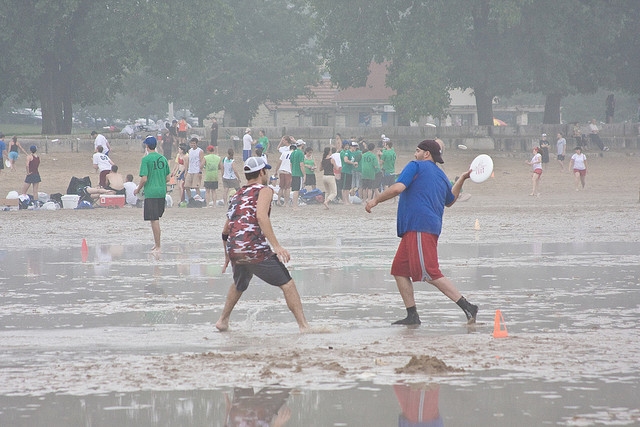

Style Images:


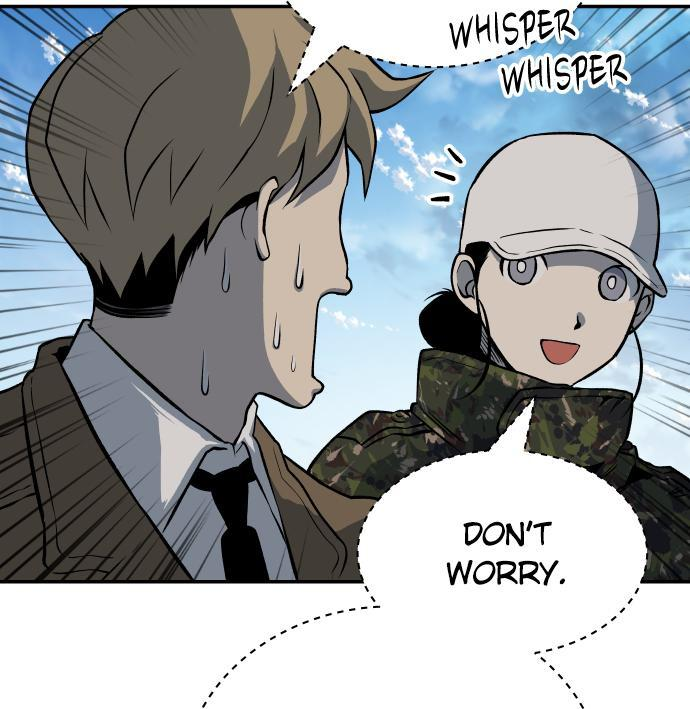

Similarity Score 0.9823749


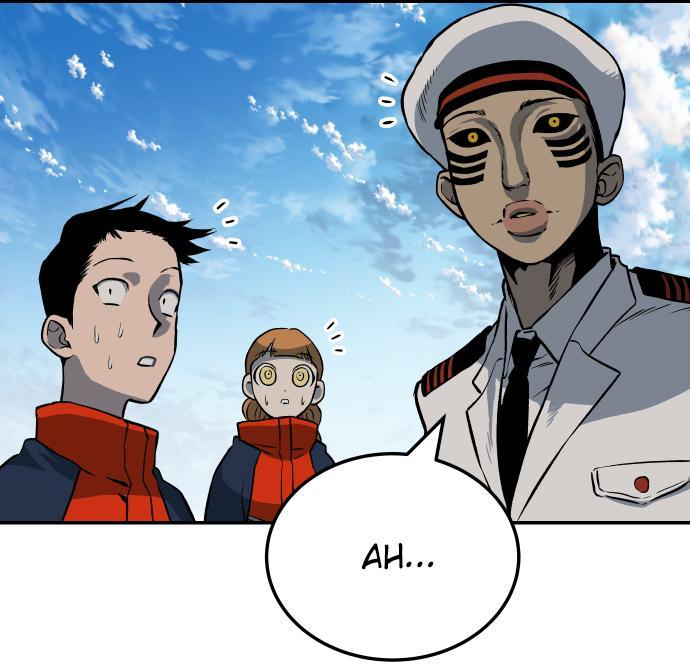

Similarity Score 0.9809919


In [82]:
series = 'ZOMGAN' # select series to style with
content_idx = 1 # select index for content image filepath
k = 2 # Number of similar style images to return
image_size = 512

device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

content_path = os.path.join('content_images', os.listdir('content_images')[content_idx]) # Edit path if you want to choose your own image
content_image = Image.open(content_path)
content_input = load_image(content_image, image_size)

content_image_embedding = encode_pil_images(content_image)[0]

similar_points = similarity_search(qclient, collection_name, content_image_embedding, series, k) # Cosine Similarity

style_images = [point_to_image(similar_point) for similar_point in similar_points]
style_inputs = [load_image(style_image, image_size) for style_image in style_images]

print("Content Image:")
display(content_image)
print("Style Images:")
for idx in range(k):
    display(style_images[idx])
    print(f"Similarity Score {similar_points[idx].score}")

## Neural Style Transfer

styling image 0
step 0


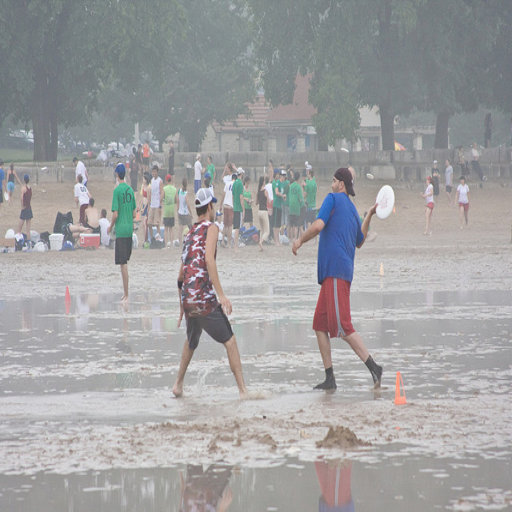

step 150


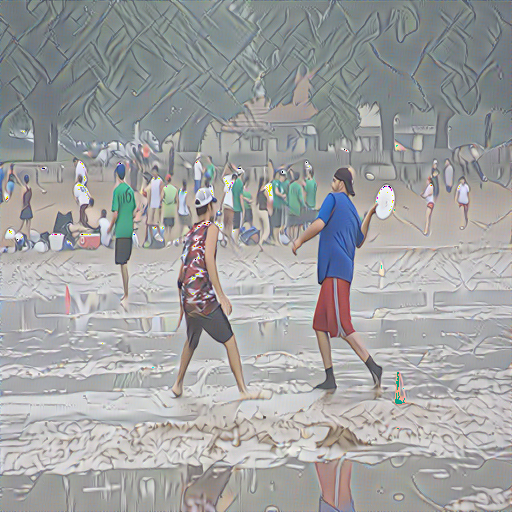

step 300


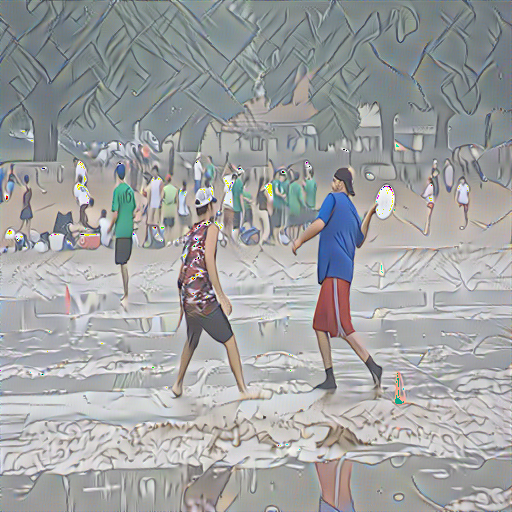

step 450


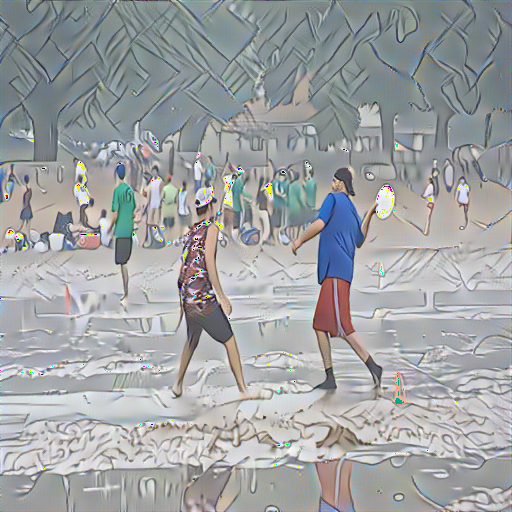

styling image 1
step 0


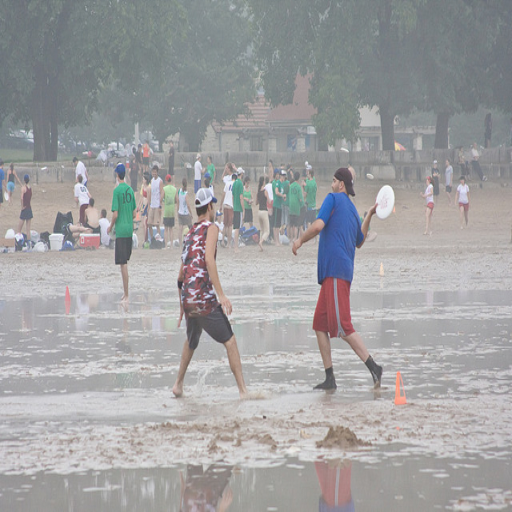

step 150


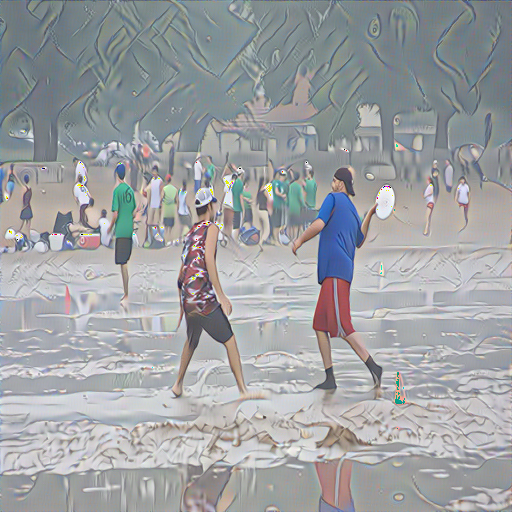

step 300


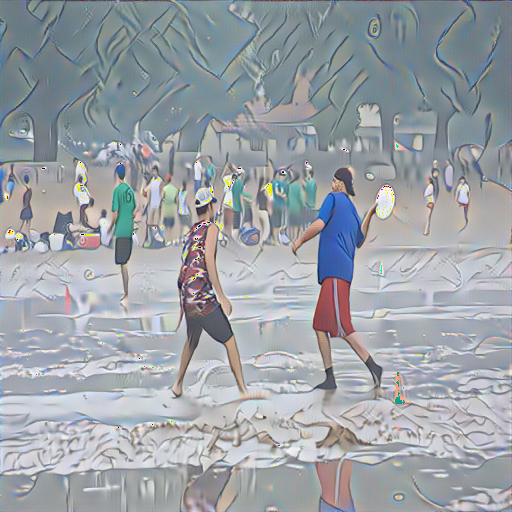

step 450


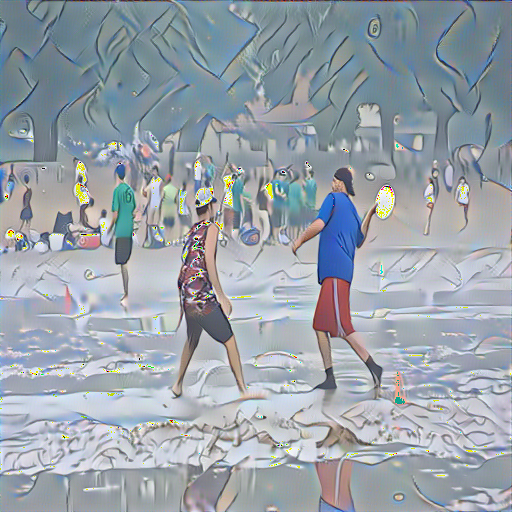

In [85]:
for idx, style_input in enumerate(style_inputs):
    print(f"styling image {idx}")
    model = VGG().to(device).eval()
    
    #generated_image= torch.randn(original_img.shape, device=device, requires_grad=True) # Noise
    generated_image = content_input.clone().requires_grad_(True) # Content image
    
    # Hyperparameters
    total_steps = 600
    learning_rate = 0.001
    alpha = 1 # content weight for loss
    beta = 0.01 # stlye weight for loss
    optimizer = optim.Adam([generated_image], lr=learning_rate)
    
    # Training (Style Transferring)
    for step in range(total_steps):
        generated_features = model(generated_image)
        content_features = model(content_input)
        style_features = model(style_input)
    
        style_loss = original_loss = 0
    
        for gen_feature, orig_feature, style_feature in zip(generated_features, content_features, style_features):
            batch_size, channel, height, width = gen_feature.shape
            original_loss += torch.mean((gen_feature - orig_feature) ** 2)
    
            G = gen_feature.view(channel, height*width).mm(gen_feature.view(channel, height*width).t()) # Gram matrices for generated image
    
            A = style_feature.view(channel, height*width).mm(style_feature.view(channel, height*width).t()) # Gram matrices for style image
    
            style_loss += torch.mean((G - A) ** 2)
    
        total_loss = alpha*original_loss + beta*style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
        if step % 150 == 0:
            print(f"step {step}")
            tensor_to_image = transforms.ToPILImage()
            display(tensor_to_image(generated_image[0])) # file type depends on content image file type
        